In [1]:
from stopwords import stopwords

from dataclasses import dataclass
from dataclasses import asdict
from pathlib import Path
import string
import random
import uuid
import json
import os
import re

import matplotlib.pyplot as plt
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import openai

In [2]:
@dataclass
class Paper:
    title: str
    abstract: str
    keywords: list[str]
    issue_date: str
    language: str
    paper_pdf: str
    abstract_eng: str | None = None
    is_ai: bool | None = None
    year: int | None = None
    id: str | None = None

def load_papers(json_file_path):
    
    with open(json_file_path) as f:
        papers_dict_list = json.load(f)
       
    papers = [Paper(**paper_dict) for paper_dict in papers_dict_list]

    if papers[0].__dict__.get('year') is None:
        for paper in papers:
            paper.year = int(paper.issue_date.split('-')[-1])

    return papers

def save_papers_to_json(papers: list[Paper], json_file_path):
     
    papers_as_dicts = [asdict(paper) for paper in papers]
     
    with open(json_file_path, 'w') as json_file:
        json.dump(papers_as_dicts, json_file)

In [3]:
class TextPreprocessor:
    def __init__(self, data: list[str] = None):
        self.data = data

    def load(self, data):
        self.data = data
        return self
    
    def to_lower(self):
        self.data = list(map(lambda x: x.lower(), self.data))
        return self
    
    def remove_punctuation(self):
        self.data = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), self.data))
        return self
    
    def get_gpt_classification(self):
        self.data = list(map(lambda x: False if x.split()[0] == 'não' else True, self.data))
        return self
    
    def remove_escape_sequences(self):
        self.data = list(map(lambda x: re.sub(r'\s+',' ',x).strip(), self.data))
        return self
    
    def remove_stopwords(self, stopwords: list[str] = stopwords):
        self.data = list(map(
            lambda x: ' '.join([ word for word in x.split() if word.lower() not in stopwords]),
            self.data))
        return self

def papers_info(papers, return_df=False):
    if papers[0].__dict__.get('year') is None:
        for paper in papers:
            paper.year = int(paper.issue_date.split('-')[-1])

    papers_since_2010 = [paper for paper in papers if paper.year >= 2010]
    num_papers_since_2010 = len(papers_since_2010)

    data = {}

    for paper in papers_since_2010:
        if paper.year not in data:
            data[paper.year] = 1
        else:
            data[paper.year] += 1

    print(f'Num of papers: {len(papers)}')
    print(f'Num of papers since 2010: {num_papers_since_2010}')
    print('Distribution of papers since 2010: ')
    print(data)

    if return_df:
        return pd.DataFrame.from_dict({'Ano': list(data.keys()), 'Quantidade': list(data.values())})

def filter_info(gpt_response_file):
    with open(gpt_response_file) as f:
       resps = json.load(f)
    
    num_papers = len(resps['papers'])
    num_papers_ai = np.sum(resps['gpt_filters'])

    print(f'Número de papers: {num_papers}')
    print(f'Número de papers AI: {num_papers_ai}')


def random_paper_info(papers):
    index = random.randint(0, len(papers)-1)
    paper = papers[index]
    return asdict(paper)
    

## Análise

In [4]:
papers_teses = load_papers('dataset/papers_teses_ai_ref.json')
papers_tcc = load_papers('dataset/papers_tcc_ai_ref.json')
papers = papers_teses + papers_tcc

In [5]:
teses_df = papers_info(papers_teses, return_df=True)

Num of papers: 91
Num of papers since 2010: 91
Distribution of papers since 2010: 
{2020: 4, 2019: 36, 2018: 34, 2017: 17}


In [6]:
tcc_df = papers_info(papers_tcc, return_df=True)

Num of papers: 110
Num of papers since 2010: 110
Distribution of papers since 2010: 
{2010: 3, 2011: 1, 2012: 1, 2013: 8, 2014: 1, 2015: 2, 2016: 2, 2017: 6, 2018: 9, 2019: 13, 2020: 12, 2021: 16, 2022: 18, 2023: 16, 2024: 2}


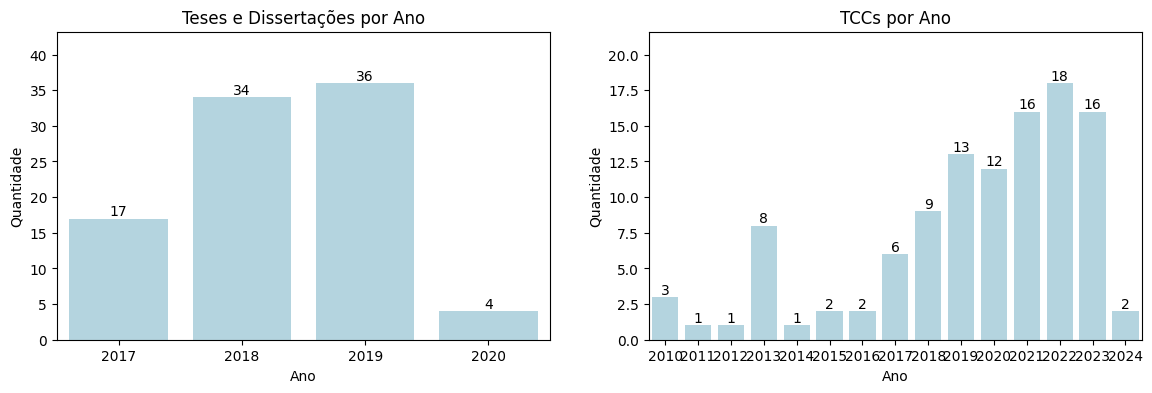

In [7]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

sns.barplot(teses_df, x="Ano", y="Quantidade", color='lightblue', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10)
ax[0].set_title('Teses e Dissertações por Ano')
ax[0].margins(y=0.2)

sns.barplot(tcc_df, x="Ano", y="Quantidade", color='lightblue', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10)
ax[1].set_title('TCCs por Ano')
ax[1].margins(y=0.2)

plt.show()


In [8]:
papers_df = papers_info(papers, return_df=True)

Num of papers: 201
Num of papers since 2010: 201
Distribution of papers since 2010: 
{2020: 16, 2019: 49, 2018: 43, 2017: 23, 2010: 3, 2011: 1, 2012: 1, 2013: 8, 2014: 1, 2015: 2, 2016: 2, 2021: 16, 2022: 18, 2023: 16, 2024: 2}


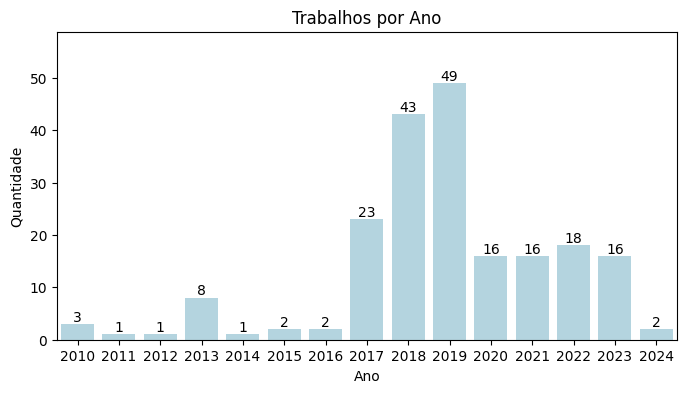

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(papers_df, x="Ano", y="Quantidade", color='lightblue')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title('Trabalhos por Ano')
ax.margins(y=0.2)
plt.show()

In [10]:
def check_papers(paper):
    print(gpt_prompt_clf(paper.title, paper.abstract, paper.keywords))
    print('\n\n')
    return asdict(paper)

## Filtragem GPT

In [11]:
papers_tcc = load_papers('data/papers_tcc.json')
papers_teses = load_papers('data/papers_teses.json')
papers = papers_tcc + papers_teses
papers_info(papers)

Num of papers: 17314
Num of papers since 2010: 15886
Distribution of papers since 2010: 
{2010: 695, 2011: 630, 2012: 453, 2013: 1021, 2014: 575, 2015: 472, 2016: 918, 2017: 1656, 2018: 1937, 2019: 1911, 2020: 937, 2021: 1849, 2022: 1942, 2023: 831, 2024: 59}


In [12]:
papers_since_2010 = [paper for paper in papers if paper.year >= 2010]

In [15]:
random_paper_info(papers)

{'title': 'Reconhecimento de padrões de condições de funcionamento de rolamentos em máquinas rotativas com auxílio de redes neurais artificiais',
 'abstract': 'Este  trabalho  apresenta  o estudo  sobre  a  aplicação  de  redes  neurais  artificiais para reconhecimento de padrões de condição de rolamentos em máquinas rotativas. Em um modelo experimental, localizado no Laboratório de Acústica e Vibrações da UFRJ, foram   medidos   sinais   de   vibração   em um   mancal   específico.   As   condições   de funcionamento  da  máquina  foram  alteradas  trocando  o  rolamento  que  funcionava  de forma  padrão,  por  um  rolamento  defeituoso.  Os  sinais  foram medidos utilizando acelerômetros.  Com  o  auxílio  do software LabVIEW,  através  do  segmento  Signal Express,  pertencente  a  National  Instruments,  foi  possível  a  visualização  e  exportação dos dados para um formato que pudesse ser tratado pelo softwareMATLAB. Os dados foram   divididos   em   pacotes   de   amostras   me

In [ ]:
load_dotenv()
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [16]:
def gpt_prompt_clf(title, abstract, keywords):

    instruction = f'Você deve identificar artigos científicos que são sobre Inteligência Artificial.'\
                   ' Dado o título, resumo e palavras-chave do artigo científico, diga se o artigo é sobre técnicas que utilizam Inteligência Artificial.'\
                   ' O artigo deve utilizar diretamente técnicas de Inteligência Artificial e não somente técnicas que podem estar relacionadas à Inteligência Artificial.'\
                   ' Responda apenas com "sim" ou "não".'
    
    prompt = f'{instruction}\n\nTítulo: {title}\n\nResumo: {abstract}\n\nPalavras-chave: {keywords}'
    
    return prompt

print(gpt_prompt_clf('titulo', 'abs', 'kw1'))

Você deve identificar artigos científicos que são sobre Inteligência Artificial. Dado o título, resumo e palavras-chave do artigo científico, diga se o artigo é sobre técnicas que utilizam Inteligência Artificial. O artigo deve utilizar diretamente técnicas de Inteligência Artificial e não somente técnicas que podem estar relacionadas à Inteligência Artificial. Responda apenas com "sim" ou "não".

Título: titulo

Resumo: abs

Palavras-chave: kw1


In [ ]:
papers_to_filter = papers_since_2010

In [ ]:
tp = TextPreprocessor()

papers_gpt = []

for i, paper in enumerate(papers_to_filter):

    prompt = gpt_prompt_clf(paper.title, paper.abstract, paper.keywords)
    
    gpt_response = client.chat.completions.create(model="gpt-3.5-turbo-0125", messages=[{"role": "user", "content": prompt}])
    gpt_response_content = gpt_response.choices[0].message.content
    gpt_classification = tp.load([gpt_response_content]).remove_punctuation().to_lower().get_gpt_classification().data[0]
    
    paper.is_ai = gpt_classification
    papers_gpt.append(paper)
    print(i)
    #if i%1000 == 0 and i != 0:
        #save_papers_to_json(papers_gpt, f'data/papers_tcc_gpt_responses_{i+1}.json')

In [ ]:
def classification_profile(papers):

    total = len(papers)
    num_ai_papers = np.sum([int(paper.is_ai) for paper in papers])

    print(f'Número de papers: {total}')
    print(f'Papers classificado como AI: {num_ai_papers}')


classification_profile(papers_gpt)

In [ ]:
papers_ai = [paper for paper in papers_gpt if paper.is_ai is True]
len(papers_ai)

In [ ]:
save_papers_to_json(papers_gpt, 'data/papers_gpt_responses.json')
save_papers_to_json(papers_ai, 'data/papers_teses_ai.json')

## Download PDFs

In [ ]:
teses_dir = Path('papers/tcc')

In [ ]:
for i, paper in enumerate(papers_ai):
    paper_dir = teses_dir/str(paper.year)
    paper_dir.mkdir(exist_ok=True)

    response = requests.get(paper.paper_pdf)
    if response.status_code == 200:
        file_name = f'tcc_{paper.id}.pdf'
        with open(paper_dir/file_name, "wb") as file:
            file.write(response.content)
            print(f'file {i}')

## BERTOPIC

In [35]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic.representation import TextGeneration
from bertopic.representation import OpenAI
from transformers import pipeline
from datasets import load_dataset
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
import datamapplot
import torch
import re

In [158]:
papers_teses = load_papers('dataset/papers_teses_ai_ref.json')
papers_tcc = load_papers('dataset/papers_tcc_ai_ref.json')
papers = papers_teses + papers_tcc

- Teste com Llama 3

In [ ]:
model_checkpoint = 'rhaymison/Llama-3-portuguese-Tom-cat-8b-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_checkpoint,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)

generator = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer,
                max_new_tokens=512,
                temperature=0.3,
                pad_token_id=tokenizer.eos_token_id)

prompt_template = [{"role": "system", "content": "Você é um assistente com a tarefa de rotular tópicos de artigos científicos."},
                   {"role": "user", "content": "Eu tenho um tópico que contém os seguintes documentos:\n[DOCUMENTS]\nO tópico é descrito pelas seguintes palavras-chave: [KEYWORDS]\n\nCom base nas informações acima, extraia um pequeno rótulo de no máximo cinco palavras para o tópico. Responda somente com o rótulo."}]

prompt = tokenizer.apply_chat_template(prompt_template, add_generation_prompt=True, tokenize=False)

representation_model = TextGeneration(generator, prompt=prompt)

In [ ]:
def paper_setup(paper):
    #ext = f'{paper.title} {paper.abstract} {paper.keywords}'
    text = paper.abstract
    return text

In [ ]:
docs = [paper_setup(paper) for paper in papers]

tp = TextPreprocessor()
docs = tp.load(docs).remove_punctuation().to_lower().remove_escape_sequences().remove_stopwords().data

- ChatGPT

In [ ]:
load_dotenv()
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

prompt = 'Eu tenho um tópico que é descrito pelas seguintes palavras-chave: [KEYWORDS]\nNeste tópico, os seguintes documentos são um subconjunto pequeno, mas representativo de todos os documentos do tópico:\n[DOCUMENTS]\n\nCom base nas informações acima, forneça uma descrição de no máximo 10 palavras para este tópico. Responda somente com o rótulo.'

representation_model  = OpenAI(client, model="gpt-3.5-turbo-0125", chat=True, prompt=prompt)

In [208]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

embedding_model = SentenceTransformer("juridics/bertimbau-base-portuguese-sts-scale")
embeddings = embedding_model.encode(docs, show_progress_bar=True)
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=10, n_components=4, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 verbose=True,
 ctfidf_model=ctfidf_model,
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


In [149]:
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-06-23 16:55:03,551 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-23 16:55:03,953 - BERTopic - Dimensionality - Completed ✓
2024-06-23 16:55:03,953 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-23 16:55:03,957 - BERTopic - Cluster - Completed ✓
2024-06-23 16:55:03,958 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 24/24 [00:16<00:00,  1.48it/s]
2024-06-23 16:55:20,263 - BERTopic - Representation - Completed ✓


In [14]:
t_docs = topic_model.get_document_info(docs)
t_docs

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,application of symmetry lters on dns database ...,4,4_Previsão com redes neurais em turbulência,[Previsão com redes neurais em turbulência],[preditivo baseado redes recorrentes controle ...,Previsão com redes neurais em turbulência,0.897028,True
1,avaliação parâmetros dados construção modelo c...,-1,-1_Previsão utilizando modelos de aprendizado,[Previsão utilizando modelos de aprendizado],[aplicação deep learning auxílio previsão temp...,Previsão utilizando modelos de aprendizado,0.000000,True
2,datadriven calibration of computational combus...,6,6_Aprendizado de Máquina e Combustão,[Aprendizado de Máquina e Combustão],[implementando máquina virtual diferenciável m...,Aprendizado de Máquina e Combustão,1.000000,True
3,new methodologies machine learning assisted tu...,4,4_Previsão com redes neurais em turbulência,[Previsão com redes neurais em turbulência],[preditivo baseado redes recorrentes controle ...,Previsão com redes neurais em turbulência,1.000000,True
4,estimation of drillstring torsional vibration ...,4,4_Previsão com redes neurais em turbulência,[Previsão com redes neurais em turbulência],[preditivo baseado redes recorrentes controle ...,Previsão com redes neurais em turbulência,0.786299,False
...,...,...,...,...,...,...,...,...
196,acoplamento modelo classificador algoritmo oti...,2,2_Modelagem e otimização de energia,[Modelagem e otimização de energia],[desenvolvimento modelo previsão geração eólic...,Modelagem e otimização de energia,0.497445,False
197,llms ia generativa jogos explora interseção in...,15,15_Inteligência Artificial em Jogos de Estratégia,[Inteligência Artificial em Jogos de Estratégia],[aplicando modelos aprendizado reforço profund...,Inteligência Artificial em Jogos de Estratégia,1.000000,True
198,inteligência artificial fabricação simulacros ...,1,1_Análise de notícias e plágio.,[Análise de notícias e plágio.],[abordagens particionamento utilizando localit...,Análise de notícias e plágio.,1.000000,False
199,identificação acordes via modelos markov ocult...,11,11_Processamento de áudio e acústica.,[Processamento de áudio e acústica.],[recuperação informações musicais abordagem ut...,Processamento de áudio e acústica.,1.000000,False


In [45]:
t_docs[t_docs.Topic == 4].Document.iloc[5]

'previsão níveis precipitação usando redes neurais artificiais planejamento diversas atividades humanas tais agricultura construção transporte turismo lazer delimitadas grau condições climáticas especialmente quantidades chuvas valores temperaturas previsões climáticas definidas previsões frente impactadas negativamente dinâmica atmosferaterraoceano causando diversos níveis incertezas existem atualidade métodos tradicionais modernos auxiliam previsão condições climáticas conseguem predizer exatidão necessária tese analisadas redes neurais artificiais ajudar tarefas previsão chuva redes neurais artificiais método inteligência artificial desenvolvimento acelerado décadas recentes considerável aplicações resultados satisfatórios posicionado redes principais linhas pesquisa diversas áreas conhecimento níveis precipitação cidades equador prognosticados utilizando prognosticadores variáveis atmosféricas oceânicas resultados obtidos mostram redes neurais artificiais conseguiram predizer chuva

In [150]:
topic_model.get_topics()

{-1: [('Aprendizado de Máquina em Processos Operacionais Industriais', 1)],
 0: [('Detecção de plágio e notícias falsas em português.', 1)],
 1: [('Previsão e monitoramento de energia sustentável e eficiente.', 1)],
 2: [('Redes Neurais em Combustão e Lógica Fuzzy', 1)],
 3: [('Estimação e propagação acústica utilizando redes neurais.', 1)],
 4: [('Tecnologias emergentes na auditoria e contabilidade empresarial', 1)],
 5: [('Processamento de áudio e acústica em diversos contextos', 1)],
 6: [('Inteligência Artificial em Esportes e Jogos Digitais', 1)],
 7: [('Detecção de resistência e tropismo viral em HIV.', 1)],
 8: [('Detecção e classificação de partículas em experimentos.', 1)],
 9: [('Previsão e análise de variações climáticas e falhas.', 1)],
 10: [('Análise de mineração de dados no mercado financeiro', 1)],
 11: [('Exploração geológica e petróleo através de dados.', 1)],
 12: [('Aprendizado de máquina em robótica e jogos competitivos.', 1)],
 13: [('Sistema de Previsão e Suporte

In [156]:
topic_model.get_topic_freq()

,Topic,Count
3,-1,42
7,0,19
8,1,18
2,2,11
6,3,8
13,4,8
12,5,7
15,6,7
1,7,7
14,8,7


In [155]:
topic_model.get_representative_docs()

{-1: ['acompanhamento variáveis processo fundamental conhecimento correção condições operacionais plantas industriais processos químicos bioquímicos sensores comerciais modelos fenomenológicos forneçam solução convencional complexidade linearidade processos impõe dificuldades medição variáveis interesse resposta problemas soluções baseadas aprendizado máquina – tais redes neuronais – propostas atual contexto big data historiadores processo tornaram indústrias modernas ambiente rico propício modelos preditivos baseados dados literatura indica somente competitividade resolução problemas redes neuronais métodos clássicos capacidade generalista modelagem matemática clara fácil compreensão engenheiro processos importância estabelecimento metodologias implementação modelos preditivos alcançando benefícios redução custos operacionais incremento confiabilidade operacional propõe metodologias implementação diagnóstico qualidade sensores virtuais offline online baseado redes neuronais multilayer

In [151]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,42,-1_Aprendizado de Máquina em Processos Operaci...,[Aprendizado de Máquina em Processos Operacion...,[acompanhamento variáveis processo fundamental...
1,0,19,0_Detecção de plágio e notícias falsas em port...,[Detecção de plágio e notícias falsas em portu...,[notícias falsas existem tempo avanço mídias s...
2,1,18,1_Previsão e monitoramento de energia sustentá...,[Previsão e monitoramento de energia sustentáv...,[monitoramento emissões necessário planta indu...
3,2,11,2_Redes Neurais em Combustão e Lógica Fuzzy,[Redes Neurais em Combustão e Lógica Fuzzy],[pt neuroevolução redes neurais treinadas util...
4,3,8,3_Estimação e propagação acústica utilizando r...,[Estimação e propagação acústica utilizando re...,[testes destrutivos destrutivos base entender ...
5,4,8,4_Tecnologias emergentes na auditoria e contab...,[Tecnologias emergentes na auditoria e contabi...,[campo pesquisa ecossistemas software recebido...
6,5,7,5_Processamento de áudio e acústica em diverso...,[Processamento de áudio e acústica em diversos...,[caracterização tamanhos partículas sólidas de...
7,6,7,6_Inteligência Artificial em Esportes e Jogos ...,[Inteligência Artificial em Esportes e Jogos D...,[aprendizado reforço permite realizado treinam...
8,7,7,7_Detecção de resistência e tropismo viral em ...,[Detecção de resistência e tropismo viral em H...,[desenvolvimento antagonistas correceptores – ...
9,8,7,8_Detecção e classificação de partículas em ex...,[Detecção e classificação de partículas em exp...,[dissertação apresenta implementações detector...


In [ ]:
topics = []

llm_labels = [re.sub(r'\\W+', ' ', label[0][0].split("\\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)['Main'].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="Trabalhos UFRJ AI",
   sub_title="Principais tópicos de trabalhos da UFRJ relacionados à AI",
   label_wrap_width=20,
   use_medoids=True)